In [ ]:
import sys
import os
import numpy as np
import pandas as pd
from keras.layers import Dense , Embedding , LSTM , Dropout , Bidirectional , GRU
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import utils
from tensorflow.keras import utils
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import text, sequence


In [ ]:
from keras.layers import Embedding, Dense, Dropout, Input#, LSTM, Bidirectional
from keras.layers import MaxPooling1D, Conv1D, Flatten, LSTM
from keras.preprocessing import sequence#, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix as confmat,
    classification_report as creport
)

from utils import *

np.random.seed(42)

In [ ]:
!wget https://archive.org/download/aravec2.0/www_sg_300.zip

--2022-03-13 11:58:19--  https://archive.org/download/aravec2.0/www_sg_300.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia803107.us.archive.org/0/items/aravec2.0/www_sg_300.zip [following]
--2022-03-13 11:58:19--  https://ia803107.us.archive.org/0/items/aravec2.0/www_sg_300.zip
Resolving ia803107.us.archive.org (ia803107.us.archive.org)... 207.241.232.157
Connecting to ia803107.us.archive.org (ia803107.us.archive.org)|207.241.232.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 528937879 (504M) [application/zip]
Saving to: ‘www_sg_300.zip’

www_sg_300.zip      100%[===================>] 504.43M   510KB/s    in 20m 56s 

2022-03-13 12:19:16 (411 KB/s) - ‘www_sg_300.zip’ saved [528937879/528937879]



In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz

--2022-03-13 22:42:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500982519 (4.2G) [application/octet-stream]
Saving to: ‘cc.ar.300.bin.gz’

cc.ar.300.bin.gz    100%[===================>]   4.19G  33.9MB/s    in 98s     

2022-03-13 22:44:18 (43.7 MB/s) - ‘cc.ar.300.bin.gz’ saved [4500982519/4500982519]



In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

--2022-03-13 22:44:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  48.6MB/s    in 26s     

2022-03-13 22:44:48 (46.6 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [ ]:
from zipfile import ZipFile
with ZipFile('/content/www_sg_300.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
data = pd.read_csv('clean_final_df.csv' , lineterminator='\n')

In [ ]:
data['dialect'].dropna

<bound method Series.dropna of 0         IQ
1         IQ
2         IQ
3         IQ
4         IQ
          ..
458192    BH
458193    BH
458194    BH
458195    BH
458196    BH
Name: dialect, Length: 458197, dtype: object>

In [ ]:
data.head()

,id,dialect,tweet
0,1175358310087892992,IQ,لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,يعني هذا محسوب على البشر .. حيونه ووحشيه .. و...
2,1175450108898565888,IQ,مبين من كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين هل الغيبه اخ محمد


In [ ]:
algo = 'sg' # or 'cbow'
path = '/content/www_sg_300'.format(algo)
#path = '/content/cc.ar.300.vec.gz'

In [ ]:
CLASSES_LIST = ['IQ', 'LY', 'QA', 'PL','SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ','EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH']


data['dialect'] = data['dialect'].apply(CLASSES_LIST.index)

X_train , X_test , y_train , y_test = train_test_split(data['tweet'] , data['dialect'] , test_size = 0.20 , random_state = 53)
print('Label categories: ' + str(CLASSES_LIST))


MAX_TEXT_LENGTH = data.tweet.map(lambda x: len(x)).max()
print(MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Label categories: ['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ', 'EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH']
320


In [ ]:
# language model
WORD_MODEL,  MAX_FEATURES, EMBED_SIZE , n_words = get_init_parameters(path)#, ext='vec')

In [ ]:
x_vec_train, x_vec_test, word_index = get_train_test(X_train, X_test, n_words, MAX_TEXT_LENGTH)


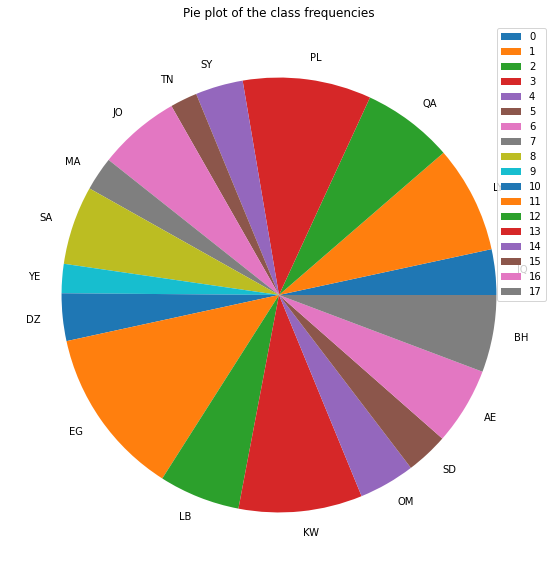

In [ ]:
LABELS = (
    'IQ', 'LY', 'QA', 'PL','SY', 'TN','JO', 'MA', 'SA','YE', 'DZ','EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH'
)

tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS)
plt.legend(unique)
plt.savefig("/content/stats_classes.png")
plt.show();

In [ ]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 2000

Original sequence length : 320


In [ ]:
print(len(word_index))

483489


In [ ]:

#le = LabelEncoder()
#data["dialect"] = le.fit_transform(data["dialect"]).astype(int)
#X_train , X_test , y_train , y_test = train_test_split(data['tweet'] , data['dialect'] , test_size = 0.25 , random_state = 53)
#y_test = np_utils.to_categorical(y_test,18)
#y_train = np_utils.to_categorical(y_train,18)
#test_cat_y = np_utils.to_categorical(y_test, 18)

In [ ]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    DOC
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = LSTM(units=32, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
    
    model = LSTM(units=16, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
        
    model = Flatten()(model)
        
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(5, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    """
    DOC
    """
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_vec_train, x_vec_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    """
    DOC 
    """
    history = model.fit(x_vec_test, y_train,
                        batch_size=batch_size/4,
                        epochs=epochs, verbose=1,
                        validation_data=(x_vec_test, y_test))#,
                        #callbacks=[TestCallback((x_v_test, y_test))])
    return history, model

In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)


Building embedding matrix...
